# Solar Energy Power Generation Dataset - Plant_1

## this notebook uses weather data to forecast solar output - https://www.kaggle.com/datasets/pythonafroz/solar-power for 2 stations Plant_1 and Plant_2

# Since solar panels convert sunlight into DC power that is what we will look at, an inverter is then used to convert this into AC power - so obviously they correlate strongly with each other but we only need to view the DC case.

# Very high accuracy is achieved due to this strong correlation.

In [165]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_profiling
import seaborn as sns
import datetime as dt
import math

import xgboost as xgb# for XGBoost algorithm
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Set the default plot size
plt.rcParams['figure.figsize'] = [15, 8]
# set a grid for each plot too
sns.set_style("whitegrid")

## Load the data for the first plants weather

In [3]:
df_weather1 = pd.read_csv('../input/solar-power/Plant_1_Weather_Sensor_Data.csv')
df_weather1

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0
...,...,...,...,...,...,...
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0


# check for missing values - there are none

In [4]:
df_weather1.isna().sum()

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

In [5]:
df_weather1.dtypes

DATE_TIME               object
PLANT_ID                 int64
SOURCE_KEY              object
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
dtype: object

# Convert DATE_TIME column to datetime datatype and make it the index

In [6]:
df_weather1['DATE_TIME'] = pd.to_datetime(df_weather1['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
df_weather1.set_index('DATE_TIME',inplace=True)
df_weather1

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0
...,...,...,...,...,...
2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0


## How many different values are there for the SOURCE_KEY - 1

In [7]:
df_weather1.SOURCE_KEY.unique()

array(['HmiyD2TTLFNqkNe'], dtype=object)

# With the date_time field now set as the index it is possible to do some quick simple graphs to investigate the data. 
## Some potential problems with the data can be seen so some further investigation may be warranted later.
# But the diurnal pattern of solar irradiation can easily be seen with some variations 

<AxesSubplot: xlabel='DATE_TIME', ylabel='IRRADIATION'>

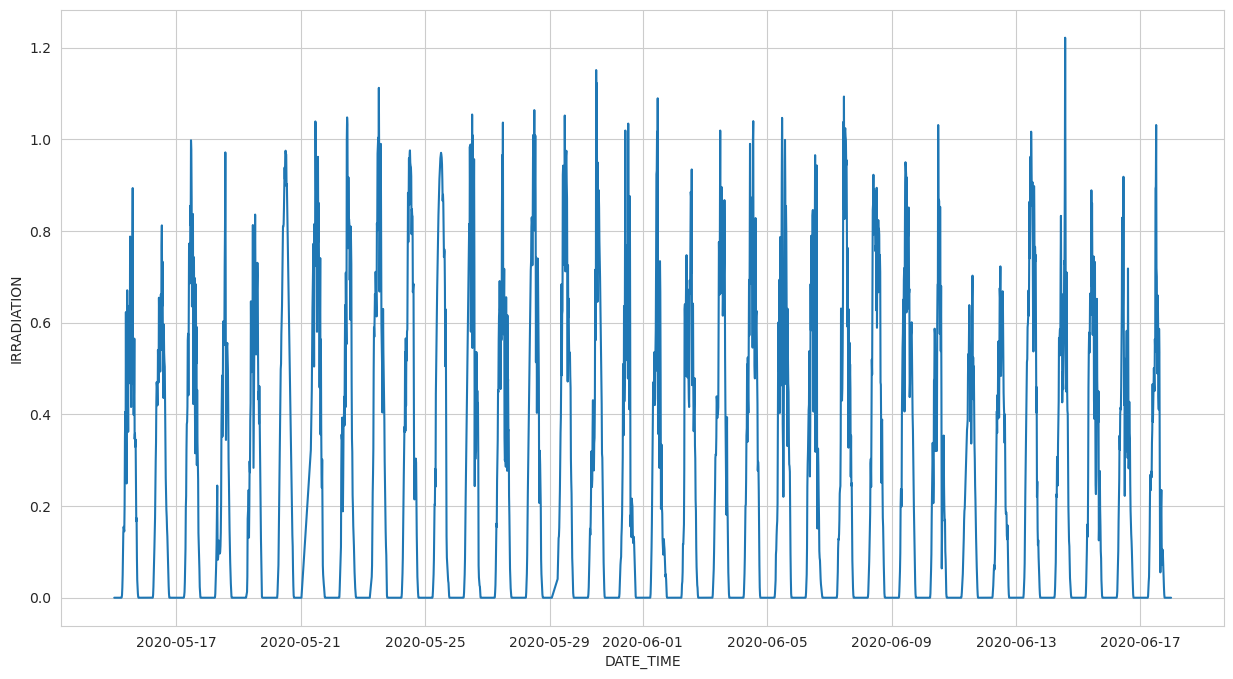

In [8]:
sns.lineplot(data='df_weather1', x=df_weather1.index, y=df_weather1['IRRADIATION'])

# Now to solar generation for plant 1
## interesting point to note - it has the same number of rows as the weather data so it will be easy to join them

In [11]:
df_solar1  = pd.read_csv('../input/solar-power/Plant_1_Generation_Data.csv')
df_solar1

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


# Following the same process as above - set the DATE_TIME column to datetime datatype and make it the index.

In [13]:
df_solar1['DATE_TIME'] = pd.to_datetime(df_solar1['DATE_TIME'], format='%d-%m-%Y %H:%M')
df_solar1.set_index('DATE_TIME',inplace=True)
df_solar1

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...
2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0


# Any nullls - no

In [14]:
df_solar1.isna().sum()

PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

# How many SOURCE_KEY - 22 

In [15]:
df_solar1.SOURCE_KEY.nunique()

22

# Again with the date as the index a graph of each of the sources can be done - the generation is usually very similar for each sensor but on occasion there is some variation which might warrant further investigation

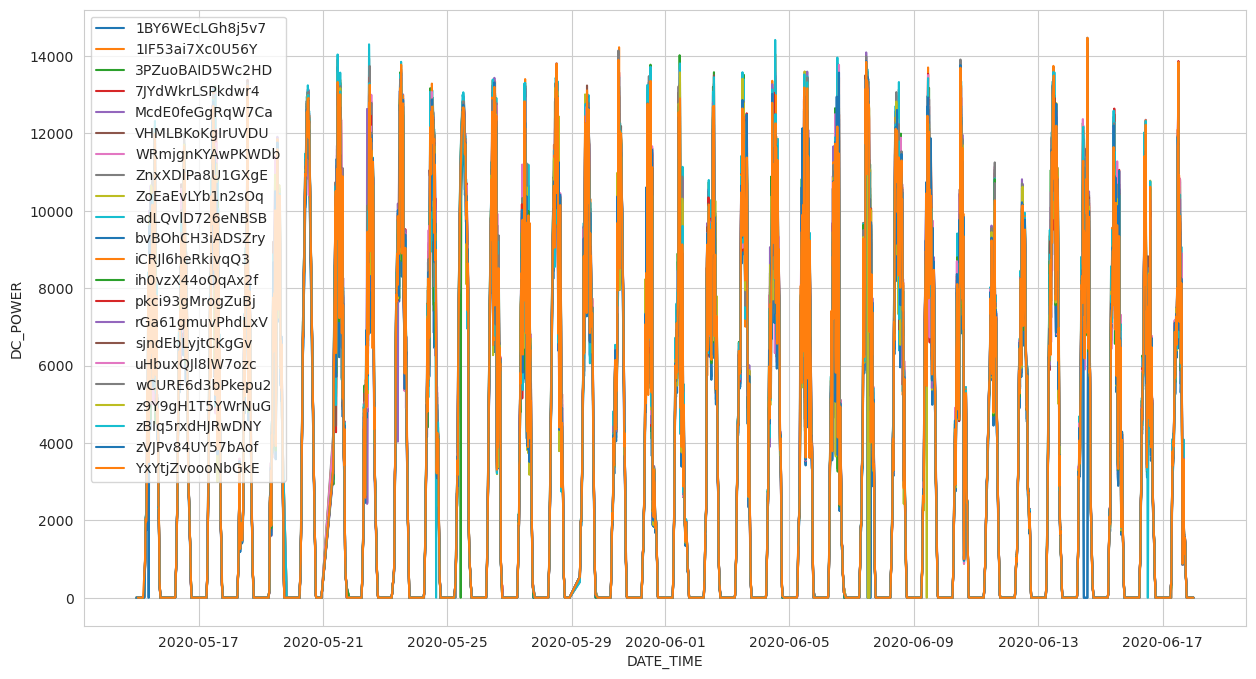

In [122]:
# Make a graph for each SOURCE_KEY

source_key = df_solar1.SOURCE_KEY.unique()    #['1BY6WEcLGh8j5v7','wCURE6d3bPkepu2','7JYdWkrLSPkdwr4']	#
for sk in source_key:
    sns.lineplot(data=df_solar1[df_solar1['SOURCE_KEY']==sk], x=(df_solar1[df_solar1['SOURCE_KEY']==sk]).index, y=df_solar1['DC_POWER'][df_solar1['SOURCE_KEY']==sk], label=sk)

In [17]:
df_solar1['2020-05-20':'2020-05-21']

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-20 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,806.125000,6290097.0
2020-05-20 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000000,6216430.0
2020-05-20 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000000,7020512.0
2020-05-20 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,1709.000000,7635208.0
2020-05-20 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000000,7192098.0
...,...,...,...,...,...,...
2020-05-21 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,7865.000000,7087976.0
2020-05-21 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,3347.571429,6832055.0
2020-05-21 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,7886.000000,7057147.0


# Putting it all together and joining the df's on index 

In [25]:
df_joined1 = pd.merge(df_solar1,df_weather1, left_on='DATE_TIME', right_on = 'DATE_TIME', how='inner', suffixes=('_solar','_weather' ))
df_joined1

,PLANT_ID_solar,SOURCE_KEY_solar,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_weather,SOURCE_KEY_weather,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,,,,
2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0
2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


# Let's drop the SOURCE_KEY and one of the PLANT_ID's


In [26]:
df_joined1.drop(['SOURCE_KEY_solar','SOURCE_KEY_weather','PLANT_ID_weather'], axis=1, inplace=True)
df_joined1

,PLANT_ID_solar,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,
2020-05-15 00:00:00,4135001,0.0,0.0,0.000,6259559.0,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,0.0,0.0,0.000,6183645.0,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,0.0,0.0,0.000,6987759.0,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,0.0,0.0,0.000,7602960.0,25.184316,22.857507,0.0
2020-05-15 00:00:00,4135001,0.0,0.0,0.000,7158964.0,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...
2020-06-17 23:45:00,4135001,0.0,0.0,5967.000,7287002.0,21.909288,20.427972,0.0
2020-06-17 23:45:00,4135001,0.0,0.0,5147.625,7028601.0,21.909288,20.427972,0.0
2020-06-17 23:45:00,4135001,0.0,0.0,5819.000,7251204.0,21.909288,20.427972,0.0


# Taking the mean output from all of the SOURCE_KEY's

In [124]:
df_group1 = df_joined1[['DC_POWER','IRRADIATION','AMBIENT_TEMPERATURE','DAILY_YIELD', ]].groupby('DATE_TIME').mean()

# Also add a column to get to the same scale - multiply the IRRADIATION by 12000 - so we can put both on the same graph.
## This graph shows the correlation between AC_POWER and IRRADIATION well.

In [128]:
df_group1['IRRADIATIONx1000'] = df_group1['IRRADIATION']*12000

Text(0.5, 1.0, 'Irradiation (x12000 for scale) versus the Daily Yield')

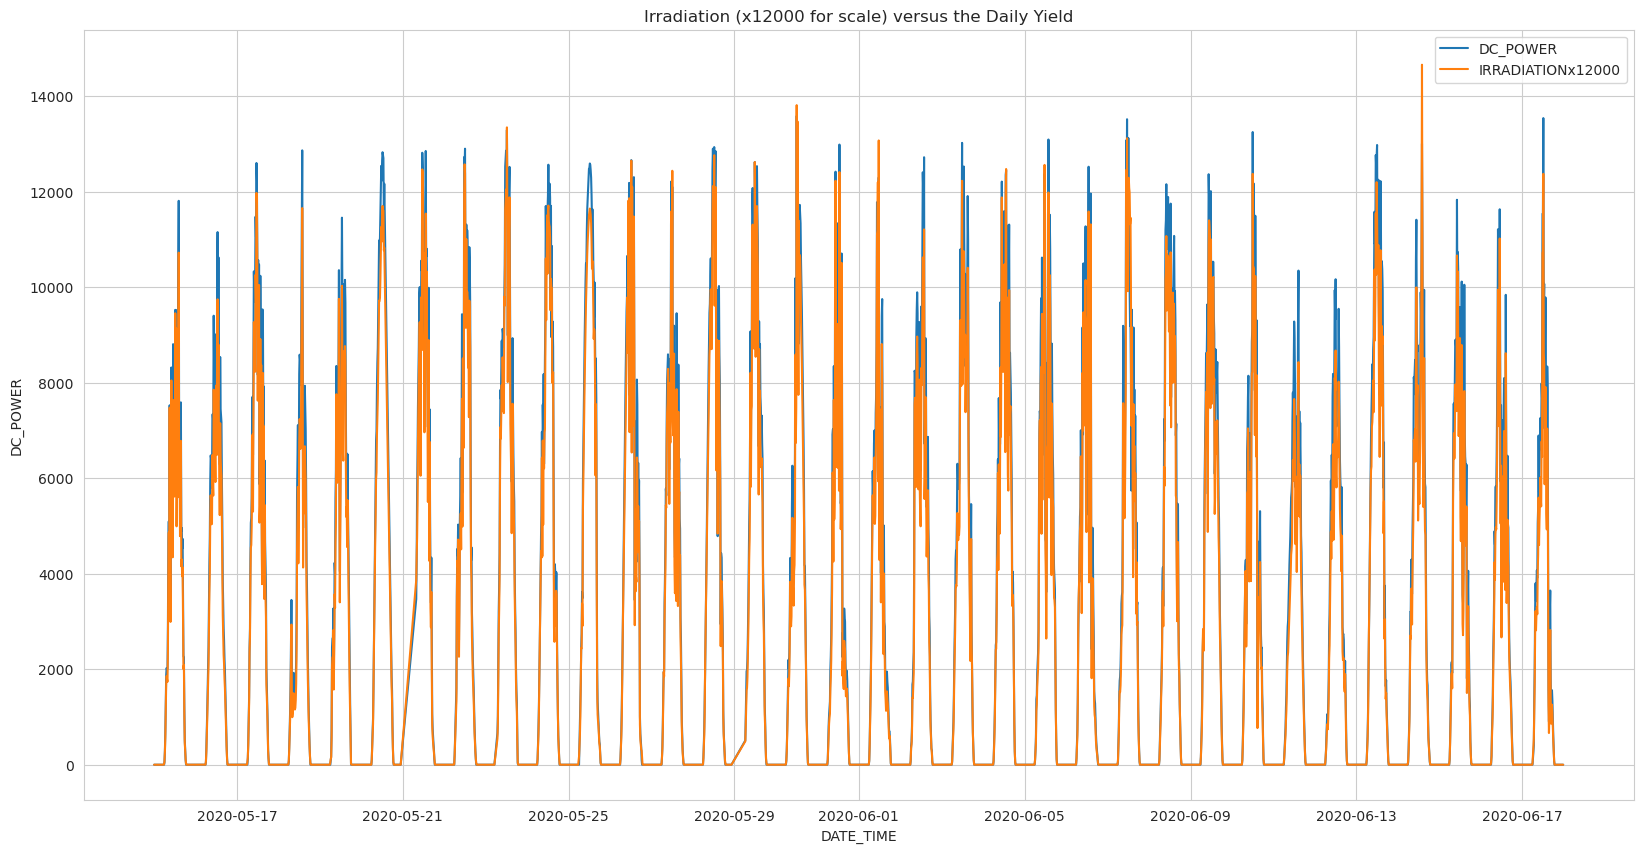

In [138]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_group1, x=df_group1.index, y='DC_POWER', label='DC_POWER')
sns.lineplot(data=df_group1, x=df_group1.index, y='IRRADIATIONx1000', label='IRRADIATIONx12000')
plt.title('Irradiation (x12000 for scale) versus the Daily Yield')

# Next lets create a correlation plot
## some things to note from this -
### DC power is 100% correlated to IRRADIATION - that's what solar panels do !
### AMBIENT_TEMPERATURE is strongly correlated to the DC power and moderately correlated to the DAILY_YIELD (presuming is it hotter when it is sunnier!)

<AxesSubplot: >

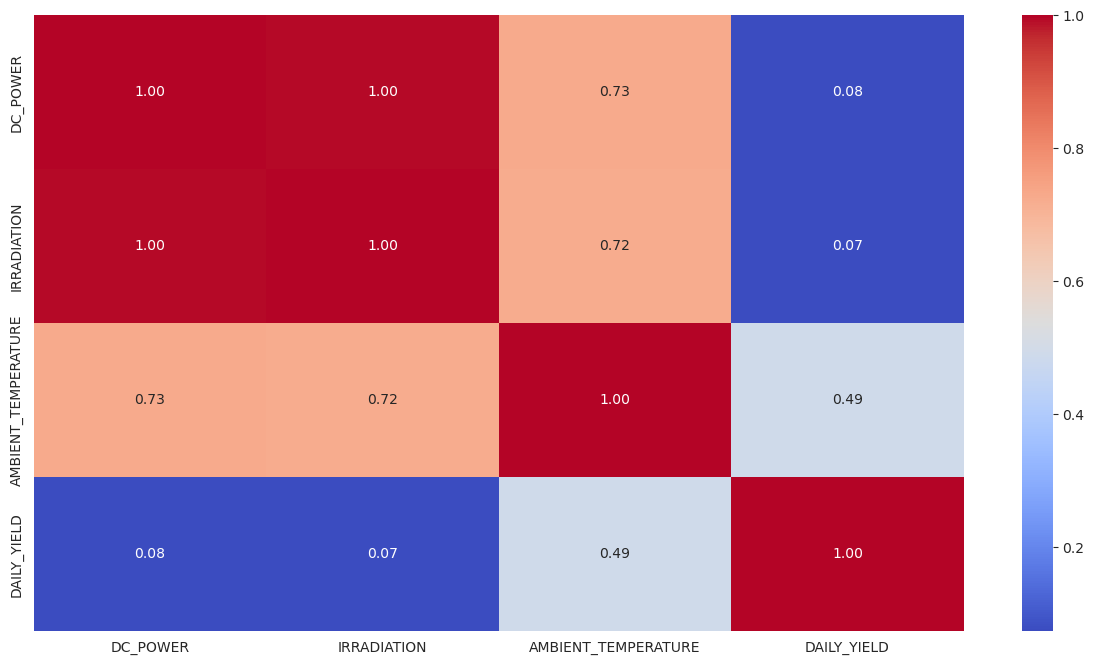

In [139]:
# get correlations for all columns except the 'IRRADIATIONx1000' that was used tfor graphing only
corr = df_group1.loc[:, df_group1.columns !='IRRADIATIONx1000'].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Based on this above graph we can see that there is an obvious relationship between IRRADIATION and the DC_POWER - next thing is to try to quantify it.

# I decided to compare the total daily values by resampling the data to D for daily and then mulitplying the IRRADIANCE by 1000 to get the same scale.
# The patterns matches almost exactly - see the graph below - remember the values aren't of the same scale so it is the pattern we are looking at.

In [142]:
# resample the data to daily values and X1000 to get IRRADIATION to the same scale
df_resample1 = df_group1.resample('D').sum()
df_resample1['IRRADIATIONx1000'] = df_resample1['IRRADIATION']*12000
df_resample1

,DC_POWER,IRRADIATION,AMBIENT_TEMPERATURE,DAILY_YIELD,IRRADIATIONx1000
DATE_TIME,,,,,
2020-05-15,255798.931278,19.037010,2551.066519,250154.709387,228444.118271
2020-05-16,263915.341722,18.651690,2356.687377,304541.118507,223820.282185
2020-05-17,307254.297619,22.931378,2561.925788,354730.240259,275176.537908
2020-05-18,218752.206168,15.266485,2289.690001,233194.988636,183197.821025
2020-05-19,249834.902688,18.044861,2356.435952,285344.798251,216538.337919
2020-05-20,244344.807736,18.245542,1911.451917,255115.275379,218946.506705
2020-05-21,308260.988439,23.556170,1816.224272,323012.292816,282674.044119
2020-05-22,291849.295510,22.119123,2546.563485,279878.597926,265429.470063
2020-05-23,346828.053734,26.106652,2393.665500,384954.229167,313279.819047


Text(0.5, 1.0, 'Daily values for total IRRADIANCE(x12000) and total DAILY_YIELD')

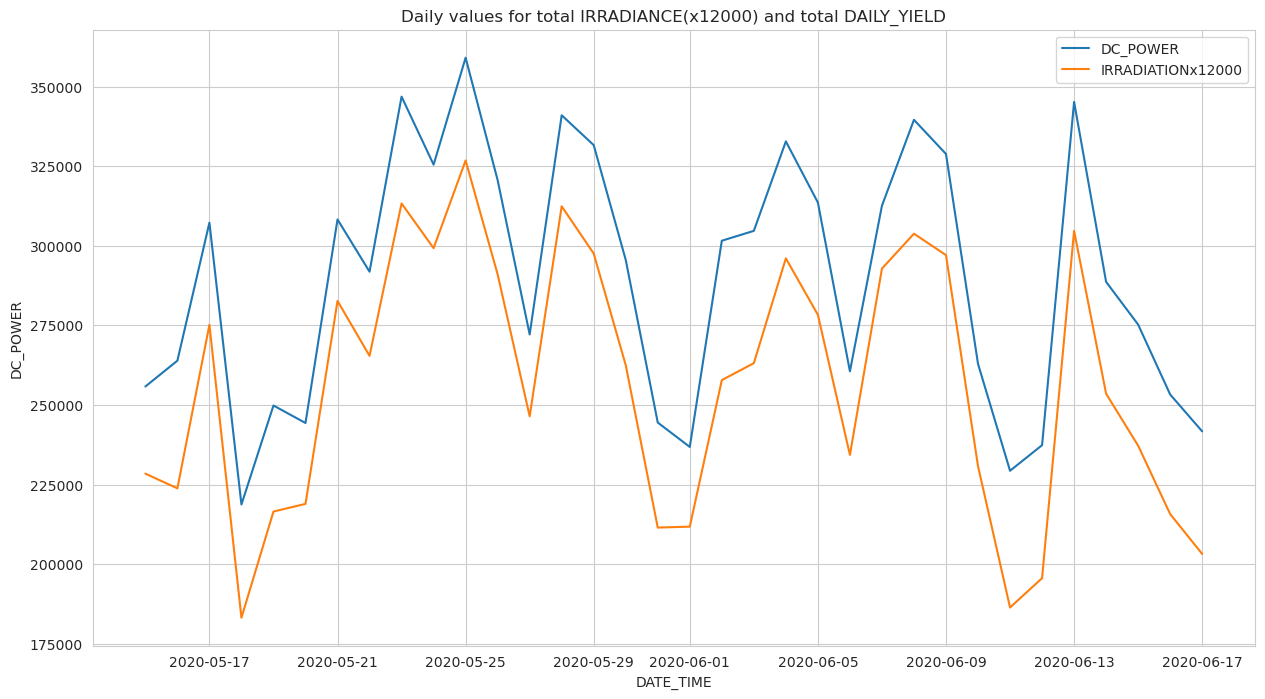

In [146]:
# Plot the newly calculated daily values

sns.lineplot(data=df_resample1, x=df_resample1.index, y='DC_POWER', label='DC_POWER')
sns.lineplot(data=df_resample1, x=df_resample1.index, y='IRRADIATIONx1000', label='IRRADIATIONx12000')
plt.title("Daily values for total IRRADIANCE(x12000) and total DAILY_YIELD")


# Because the DC power output is highly correlated to the IRRADIATION the ability of any model to forecast it would be very good - from a simply linear regression to an XGBoost model - I will do both here and compare the results.
## Split the data into a trainining set and a test set (70 training/30 testing) and then use the algorithms to make a prediction of the DC_POWER using the IRRADIATION values
## I will use the grouped data with the mean of all the sensors rather than a specific sensor.

In [162]:
# just use the IRRADIATION and AMBIENT_TEMPERATURE to predict the AC_POWER
X = df_group1.drop(['DC_POWER', 'IRRADIATIONx1000'],axis=1)
y = df_group1['DC_POWER']

In [148]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70,  shuffle=False, random_state=42) 

# Do cross verification to work out the best parameter combination

In [149]:
# A parameter grid for XGBoost
params = {
        'learning_rate': [0.001,  0.01,  0.1],
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 5, 7,9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        #'n_thread':[1,3,5]
        }

folds = 3
param_comb = 5

kf = KFold(n_splits=folds, shuffle = True, random_state = 42)

model = xgb.XGBRegressor() #learning_rate=0.01, n_estimators=1000,silent=True, eval_metric='mlogloss', nthread=1) # objective='binary:logistic',  

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=params,    n_iter=10, cv=kf, verbose=1,  scoring='neg_mean_squared_error', random_state=42)

# Here we go

random_search.fit(X_train, y_train)

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

 All results:
{'mean_fit_time': array([0.08166989, 0.36483216, 0.04410283, 0.0538644 , 0.1922458 ,
       0.04316926, 0.04701471, 0.06972019, 0.41106613, 0.04752994]), 'std_fit_time': array([0.02098531, 0.0089399 , 0.00085088, 0.0009987 , 0.0027133 ,
       0.00036785, 0.00552636, 0.00152863, 0.0404728 , 0.00187542]), 'mean_score_time': array([0.00204937, 0.00283718, 0.00166019, 0.00180022, 0.00249473,
       0.00166631, 0.00181985, 0.00180888, 0.00328247, 0.00198285]), 'std_score_time': array([6.90729343e-05, 1.36558842e-04, 5.02127616e-06, 4.29706453e-05,
       3.57957970e-05, 7.92898614e-06, 1.78426747e-04, 4.83070795e-05,
       1.16325193e-04, 3.02551851e-04]), 'param_subsample': masked_array(data=[0.6, 1.0, 0.8, 0.8, 0.8, 1.0, 0.6, 1.0, 0.6, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_reg_lam

In [151]:
# Using the best params from above we can test the model
best_params = {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.05, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 1.0}
# define the model
xgb_model = xgb.XGBRegressor(**best_params)
# fit the model
xgb_model.fit(X_train, y_train)
# make a prediction
y_pred = xgb_model.predict(X_test)
# evaluate
print('Model score: ',xgb_model.score(X_test, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred)) 
print('MSE:', mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

Model score:  0.9939444876137966
MAE: 138.38671272983618
MSE: 93458.89392329987
RMSE 305.71047401634746


# Store the results into a dataframe for plotting
## The plot shows just how accurate the prediction is 

In [157]:
df_results_xgb = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_results_xgb

,y_test,y_pred
DATE_TIME,,
2020-05-25 15:00:00,10099.922078,10061.031993
2020-05-25 15:15:00,8880.358766,9049.985730
2020-05-25 15:30:00,7893.991071,6817.568101
2020-05-25 15:45:00,8508.495941,8436.034813
2020-05-25 16:00:00,7667.707792,7425.676659
...,...,...
2020-06-17 22:45:00,0.000000,-38.608079
2020-06-17 23:00:00,0.000000,-39.205733
2020-06-17 23:15:00,0.000000,-42.705755


Text(0.5, 1.0, 'XGBoost prediction of DC_POWER (orange) and the Actual values (blue)')

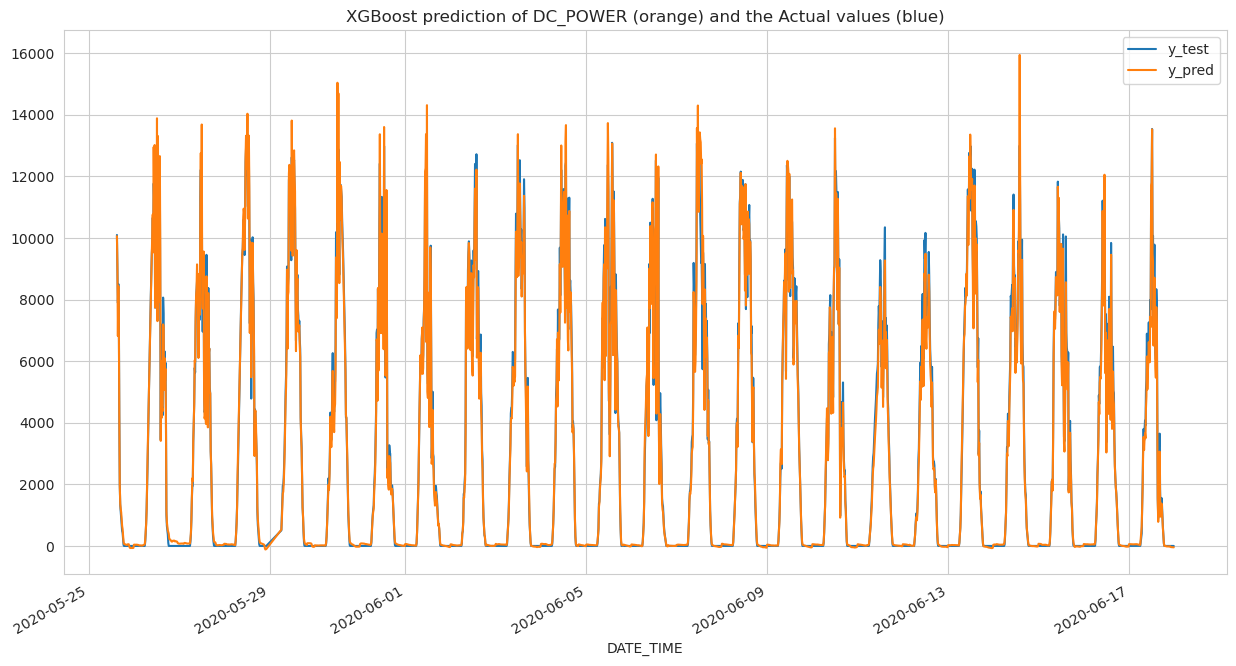

In [158]:
# Plot 
df_results_xgb.plot()
plt.title('XGBoost prediction of DC_POWER (orange) and the Actual values (blue)')

# Linear Regression model

In [161]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Model score: ',xgb_model.score(X_test, y_test))
print('MAE:', mean_absolute_error(y_test, y_pred)) 
print('MSE:', mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

Model score:  0.9939444876137966
MAE: 206.1869098856183
MSE: 147225.30666231198
RMSE 383.6995004718041


In [159]:
df_results_lr = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_results_lr

,y_test,y_pred
DATE_TIME,,
2020-05-25 15:00:00,10099.922078,10061.031993
2020-05-25 15:15:00,8880.358766,9049.985730
2020-05-25 15:30:00,7893.991071,6817.568101
2020-05-25 15:45:00,8508.495941,8436.034813
2020-05-25 16:00:00,7667.707792,7425.676659
...,...,...
2020-06-17 22:45:00,0.000000,-38.608079
2020-06-17 23:00:00,0.000000,-39.205733
2020-06-17 23:15:00,0.000000,-42.705755


Text(0.5, 1.0, 'Linear Regression prediction of DC_POWER (orange) and the Actual values (blue)')

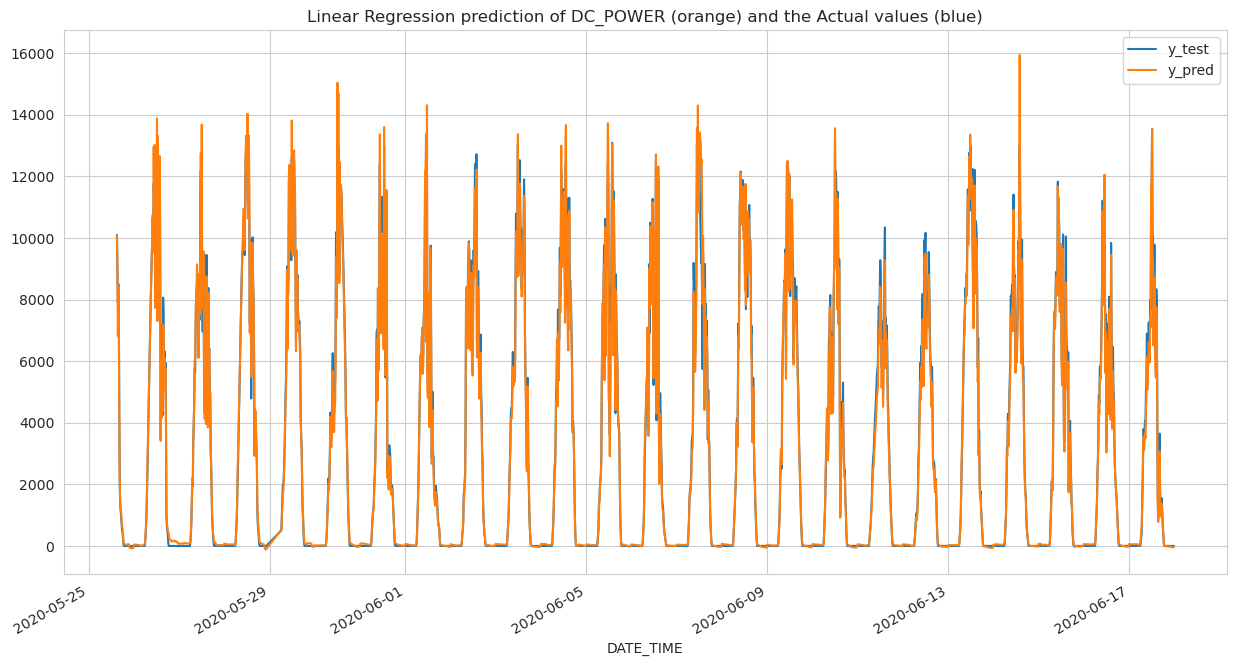

In [160]:
# Plot 
df_results_xgb.plot()
plt.title('Linear Regression prediction of DC_POWER (orange) and the Actual values (blue)')

# As expected the linear regression model was able to get the same score though a larger RMSE. 
# The data for Plant_2 is not as completas for Plant_1 hence there is a 
# This is due in fact to the strong correlation between the IRRADIATION and the DC_POWER and should be expected - in fact any other model should be able to get good results

# I will test this using the function defined below that gives output for Linear, decision tree, support vector, Lasso, random forest regression and extreme gradient boost regressors - indeed all models are able to achieve above 99% accuracy (except Support Vector regression and Lasso)


In [166]:
'''
Function to perform regressions, accuracy calculations and plots
'''    

def regression_calculations(X_train, y_train, X_test, y_test, regressor):
    #regr = regressor
    regr = regressor.fit(X_train,y_train)
    y_pred = regr.predict(X_test)
    # store the orignial and predicted value in a dataframe
    df_final = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_test })  
    
    print('Accuragy for                       ',regressor, ' = {:.4f}'.format(regr.score(X_test, y_test)))    
    print('The mean absolute error (MAE) for  ',regressor, ' = {:.2f}'.format(mean_absolute_error( df_final['Actuals'],df_final['Predictions'])))
    print('The RMSE error (RMSE) for          ',regressor, ' = {:.2f}'.format(mean_squared_error( df_final['Actuals'],df_final['Predictions']), squared=False))
    
    print('\n\n')
    
    return y_pred

In [167]:
# define the different regressors
regressors = [DecisionTreeRegressor(), SVR(), linear_model.Lasso(), RandomForestRegressor(), GradientBoostingRegressor()] 

In [168]:
pred=0
for regressor in regressors:
    pred = regression_calculations(X_train, y_train, X_test, y_test, regressor)

Accuragy for                        DecisionTreeRegressor()  = 0.9917
The mean absolute error (MAE) for   DecisionTreeRegressor()  = 165.14
The RMSE error (RMSE) for           DecisionTreeRegressor()  = 127559.47



Accuragy for                        SVR()  = -0.4214
The mean absolute error (MAE) for   SVR()  = 3016.97
The RMSE error (RMSE) for           SVR()  = 21937060.26



Accuragy for                        Lasso()  = 0.9904
The mean absolute error (MAE) for   Lasso()  = 207.86
The RMSE error (RMSE) for           Lasso()  = 147699.21



Accuragy for                        RandomForestRegressor()  = 0.9940
The mean absolute error (MAE) for   RandomForestRegressor()  = 139.09
The RMSE error (RMSE) for           RandomForestRegressor()  = 92667.84



Accuragy for                        GradientBoostingRegressor()  = 0.9940
The mean absolute error (MAE) for   GradientBoostingRegressor()  = 141.78
The RMSE error (RMSE) for           GradientBoostingRegressor()  = 92100.23



